In [58]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import random

# Import data

In [59]:
# file path to data folder
path = './Output'

In [60]:
file = path + f'/combined_data.csv'
data = pd.read_csv(file, index_col=0).fillna(pd.NA)

Visualization: plot random day of dataset (<span style="color:red">fatigued</span>, <span style="color:green">vigilant</span>)

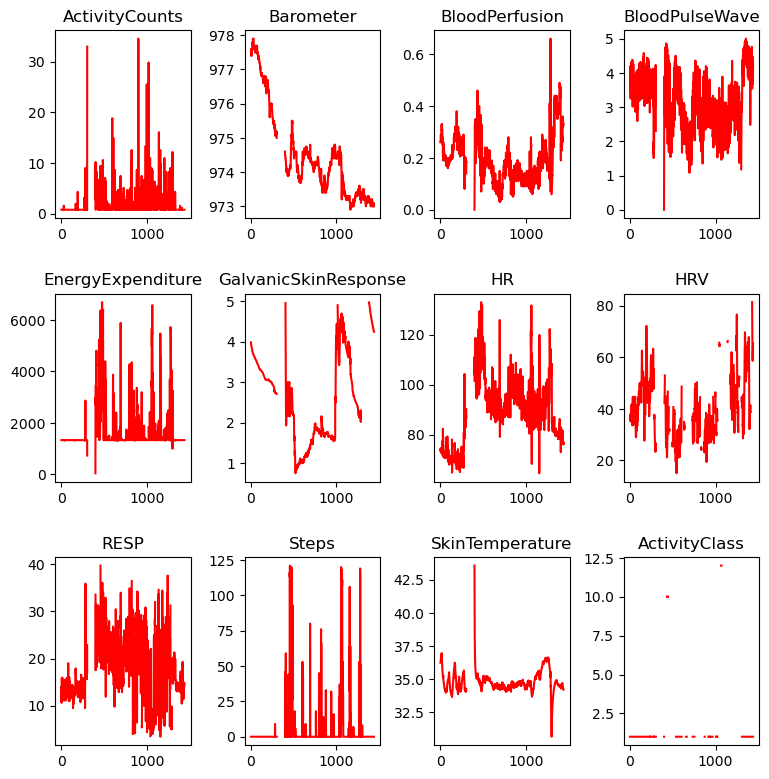

In [61]:
def plotter(figure, day):
    variables = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
                 'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
                 'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']

    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    length = len(np.array([value if value != 'None' else None for value in data['HR'][day].split(',')], dtype=float))
    for i, variable in enumerate(variables):
        time_series = np.array([value if value != 'None' else None for value in data[variable][day].split(',')], dtype=float)

        assert len(time_series) == length, 'time-series data lengths differ!'

        col = 'green' if data['VAS'][day] == 0.0 else 'red'
        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series, col)

fig = plt.figure()
day = random.sample(range(data.shape[0]), 1)[0]
plotter(fig, day)

# Filter data

In [62]:
print('Total days before filtering:', data.shape[0])

Total days before filtering: 410


In [63]:
# exclude days with >THRESHOLD (%) of data missing
THRESHOLD = 0.8
n_days, n_cols = data.shape
variables = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']

# flag deficient rows
data.insert(n_cols, "deficient", [False for i in range(n_days)], True)
for day in range(n_days):
    for variable in variables:
        time_series = np.array([value if value != 'None' else None for value in data[variable][day].split(',')], dtype=float)

        missing_data = np.mean(np.where(np.isnan(time_series), 1.0, 0.0))
        if missing_data > THRESHOLD:
            data['deficient'][day] = True

# remove deficient rows
query = '''
SELECT *
FROM data
WHERE deficient = 0;'''
data = sqldf(query)
data = data.drop(columns=['deficient']) # deficiency column is no longer required

C:\Users\jjung\AppData\Local\Temp\ipykernel_35848\3081930758.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['deficient'][day] = True


In [64]:
print(f'Total excluded days (>{THRESHOLD * 100}% missing data):', n_days - data.shape[0])
print('Total remaining days:', data.shape[0])

Total excluded days (>80.0% missing data): 92
Total remaining days: 318


# Imputation

In [65]:
def na_sequence_lengths(dat):
    # check NA sequence lengths
    n_days, n_cols = dat.shape
    variables = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
                 'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
                 'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']

    total_missing_values = 0
    na_sequences_data = []
    for day in range(n_days):
        for variable in variables:
            entry = dat[variable][day]
            time_series = np.array([value if value != 'None' else None for value in entry.split(',')], dtype=float) \
                if not isinstance(entry, np.ndarray) else entry # entry could be ndarray or string

            na_sequences = []
            na_seq = 0
            for datapoint in time_series:
                if not np.isnan(datapoint):
                    if na_seq > 0:
                        na_sequences.append(na_seq)
                        total_missing_values += na_seq
                        na_seq = 0
                else:
                    # datapoint is NA
                    na_seq += 1
            na_sequences_data += na_sequences

    # show numerical distribution of NA sequence lengths
    temp = pd.DataFrame(np.array(na_sequences_data), columns=['n'])
    query = '''
    SELECT n AS sequence_length, COUNT(*) AS occurrences
    FROM temp
    GROUP BY n'''
    temp = sqldf(query)

    # plot distribution of NA sequence lengths
    temp.plot.bar(x='sequence_length', y='occurrences', width=2, title=f'Missing data (total: {total_missing_values})')
    plt.xticks([])
    plt.xlim([-10, temp.shape[0]])

    return temp

,sequence_length,occurrences
0,1,9182
1,2,3585
2,3,1599
3,4,1001
4,5,699
...,...,...
473,1030,8
474,1031,2
475,1054,1
476,1065,1


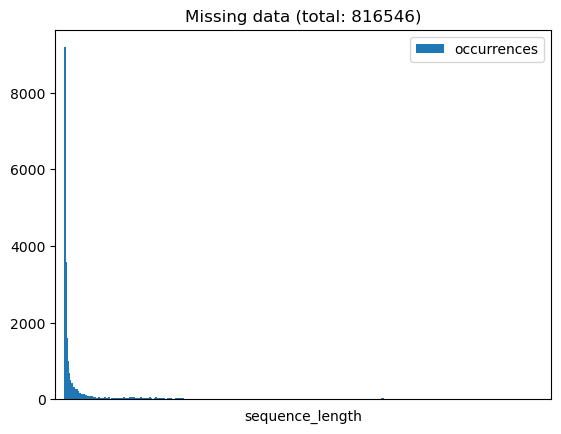

In [66]:
# before imputation
na_sequence_lengths(data)

In [67]:
# imputation
n_days, n_cols = data.shape
variables = ['ActivityCounts', 'Barometer', 'BloodPerfusion',
             'BloodPulseWave', 'EnergyExpenditure', 'GalvanicSkinResponse', 'HR',
             'HRV', 'RESP', 'Steps', 'SkinTemperature', 'ActivityClass']

for day in range(n_days):
    for variable in variables:
        time_series = np.array([value if value != 'None' else None for value in data[variable][day].split(',')], dtype=float)

        for i, datapoint in enumerate(time_series):
            if np.isnan(datapoint): # datapoint is NA
                try:
                    # single missing datapoint
                    # (in between data)
                    if not np.isnan(time_series[i-1]) and not np.isnan(time_series[i+1]):
                        time_series[i] = time_series[i-1] # forward copy
                    # (at start of data)
                    elif i == 0 and not np.isnan(time_series[i+1]):
                        time_series[i] = time_series[i+1] # backward copy
                    # (at end of data)
                    elif i == len(time_series) - 1 and not np.isnan(time_series[i-1]):
                        time_series[i] = time_series[i-1] # forward copy

                    # 2 missing datapoints
                    # (in between data)
                    elif not np.isnan(time_series[i-1]) and np.isnan(time_series[i+1]) and not np.isnan(time_series[i+2]):
                        time_series[i] = time_series[i-1] # forward copy
                        time_series[i+1] = time_series[i+2] # backward copy
                    # (at start of data)
                    elif i == 0 and np.isnan(time_series[i+1]) and not np.isnan(time_series[i+2]):
                        time_series[i] = time_series[i+2] # backward copy
                        time_series[i+1] = time_series[i+2] # backward copy
                    # (at end of data)
                    elif i == len(time_series) - 2 and np.isnan(time_series[i+1]) and not np.isnan(time_series[i-1]):
                        time_series[i] = time_series[i-1] # backward copy
                        time_series[i+1] = time_series[i-1] # backward copy

                    # 3 missing datapoints (in between data)
                    elif not np.isnan(time_series[i-1]) and np.isnan(time_series[i+1]) and np.isnan(time_series[i+2]) \
                            and not np.isnan(time_series[i+3]):
                        time_series[i] = time_series[i-1] # forward copy
                        time_series[i+1] = np.mean([time_series[i-1], time_series[i+3]]) # average forward-backward
                        time_series[i+2] = time_series[i+3] # backward copy

                    # 4 missing datapoints (in between data)
                    elif not np.isnan(time_series[i-1]) and np.isnan(time_series[i+1]) and np.isnan(time_series[i+2]) \
                            and np.isnan(time_series[i+3]) and not np.isnan(time_series[i+4]):
                        time_series[i] = time_series[i-1] # forward copy
                        time_series[i+1] = np.mean([time_series[i-1], time_series[i+4]]) # average forward-backward
                        time_series[i+2] = np.mean([time_series[i-1], time_series[i+4]]) # average forward-backward
                        time_series[i+3] = time_series[i+4] # backward copy

                    else:
                        pass
                except IndexError:
                    pass

        data[variable][day] = time_series

C:\Users\jjung\AppData\Local\Temp\ipykernel_35848\3847153885.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[variable][day] = time_series


,sequence_length,occurrences
0,3,1
1,5,699
2,6,516
3,7,419
4,8,315
...,...,...
470,1030,8
471,1031,2
472,1054,1
473,1065,1


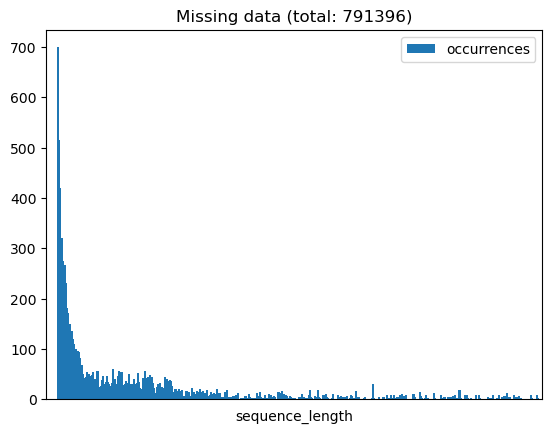

In [68]:
# after imputation
na_sequence_lengths(data)

# Segmentation

In [68]:
SEQUENCE_LENGTH = None

# Spectrogram conversion